# Peter and the Wolf: Reinforcement Learning Primer

In this tutorial, we will learn how to apply Reinforcement learning to a problem of path finding. The setting is inspired by [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) musical fairy tale by Russian composer [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). It is a story about young pioneer Peter, who bravely goes out of his house to the forest clearing to chase a wolf. We will train machine learning algorithms that will help Peter to explore the surrounding area and build an optimal navigation map.

First, let's import a bunch of useful libraries:

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Overview of Reinforcement Learning

**Reinforcement Learning** (RL) is a learning technique that allows us to learn an optimal behaviour of an **agent** in some **environment** by running many experiments. An agent in this environment should have some **goal**, defined by a **reward function**.

## The Environment

For simplicity, let's consider Peter's world to be a square board of size `width` x `height`. Each cell in this board can either be:
* **ground**, on which Peter and other creatures can walk
* **water**, on which you obviously cannot walk
* **a tree** or **grass** - a place where you can rest
* **an apple**, which represents something Peter would be glad to find in order to feed himself
* **a wolf**, which is dangerous and should be avoided

To work with the environment, we will define a class called `Board`. In order not to clutter this notebook too much, we have moved all code to work with the board into separate `rlboard` module, which we will now import. You may look inside this module to get more details about the internals of the implementation.

Let's now create a random board and see how it looks:

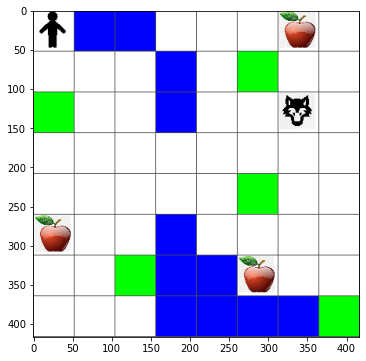

In [129]:
from rlboard import *

m = Board(8,8)
m.randomize()
m.plot()

## Actions and Policy

In our example, Peter's goal would be to find an apple, while avoiding the wolf and other obstacles. Define those actions as a dictionary, and map them to pairs of corresponding coordinate changes.

At any position, he can choose between one of the following actions: up, down, left and right.

We will define those actions as a dictionary, and map them to pairs of corresponding coordinate changes. For example, moving right (R) would correspond to a pair (1,0):

In [130]:
# Code Block 2: define a dictionary of actions and coordinates.
actions = {'L':(-1,0), 'R':(1,0), 'D':(0,-1), 'U':(0,1)}

To sum up, the strategy and goal of this scenario are as follows:

The strategy, of our agent (Peter) is defined by a so-called **policy**. A policy is a function that returns the action at any given state. In our case, the state of the problem is represented by the board, including the current position of the player.

The goal, of reinforcement learning is to eventually learn a good policy that will allow us to solve the problem efficiently. However, as a baseline, let's consider the simplest policy called **random walk**.

## Random walk

Let's first solve our problem by implementing a random walk strategy.

In [131]:
# Let's run a random walk experiment several times and see the average number of steps taken: code block 3
# Define a strategy that chooses a random action (direction).
def randomwalk(m):
    while True:
        action = random.choice(list(actions.items()))
        new_pos = m.move_pos(m.human, action[1])
        if m.is_valid(new_pos):
            return action

# Define a 'walk' function that looks a the current location (Board.at()).
#   * If we found that apple, we return the path length.
#   * If we encounter the wolf, we return -1 
#   * Otherwise, we call the strategy function to know the next move, and execute it (Board.move())
import time

def walk(m, strategy):
    path_length = 0
    while True:
        path_length += 1
        action = strategy(m)
        m.move(action[1])
        destination = m.at()
        if destination in [m.Cell.water]:
            return -1
        if destination in [m.Cell.wolf]:
            if m.energy > m.fatigue:
                return path_length
            else:
                return -1
        if path_length > 200:
            return -1

walk(m, randomwalk)

-1

In [132]:
# code block 4
# Make 100 walk experiments and print the average path length / number of times we encountered the wolf.
deaths = 0
runs = 0.00001
total_length = 0
for run in range(100):
    m.random_start()
    result = walk(m, randomwalk)
    if result < 0:
        deaths += 1
    else:
        total_length += result
        runs += 1

print(f"In 100 runs: died {deaths} times, average path length: {total_length / runs}")

In 100 runs: died 99 times, average path length: 13.999860001399986


## Reward Function

To make our policy more intelligent, we need to understand which moves are "better" than others.



In [133]:
# code block 5
# Write a `reward` function that computes the current reward of the last action:
# 10 if we reached the apple
# -10 if we died (by wolf or water)
# -0.1 for every move (this assigns a cost to walking around, and prefers shorter paths)

def reward(m):
    if not m.is_valid(m.human):
        return -10
    if m.at() in [m.Cell.water]:
        return -10
    if m.at() in [m.Cell.wolf]:
        if m.energy > m.fatigue:
            return 10
        return -10
    return -0.1

## Q-Learning

Build a Q-Table, or multi-dimensional array. Since our board has dimensions `width` x `height`, we can represent Q-Table by a numpy array with shape `width` x `height` x `len(actions)`:

In [134]:
# code block 6
# use np.ones() to create a 3-dimensional array.
# Divide the array by 4 (the length of actions) to assign each cell a value of 0.25.

Q = np.ones([m.width, m.height, 10, 10, len(actions)], np.float32) / len(actions)


Pass the Q-Table to the `plot` function in order to visualize the table on the board:

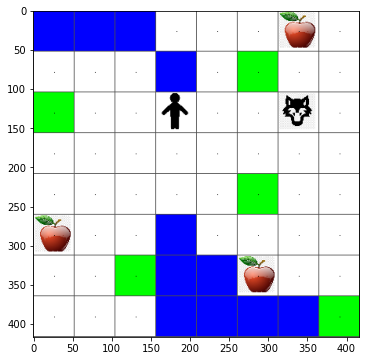

In [135]:
m.plot(Q)


## Essence of Q-Learning: Bellman Equation and  Learning Algorithm
Once we start moving, each action will have a corresponding reward, i.e. we can theoretically select the next action based on the highest immediate reward. However, in most states, the move will not achieve our goal of reaching the apple, and thus we cannot immediately decide which direction is better.

> Remember that it is not the immediate result that matters, but rather the final result, which we will obtain at the end of the simulation.

In order to account for this delayed reward, we need to use the principles of [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming), which allow us to think about out problem recursively.

Suppose we are now at the state s, and we want to move to the next state s'. By doing so, we will receive the immediate reward r(s,a), defined by the reward function, plus some future reward. If we suppose that our Q-Table correctly reflects the "attractiveness" of each action, then at state s' we will chose an action a' that corresponds to maximum value of Q(s',a'). Thus, the best possible future reward we could get at state s will be defined as $max_{a'}Q(s',a')$ (maximum here is computed over all possible actions a' at state s').

This gives the Bellman formula for calculating the value of the Q-Table at state s, given action a:

$Q(s,a) = r(s,a) +\gamma\max_{a'}Q(s',a')$

Here $\gamma$ is the so-called discount factor that determines to which extent you should prefer the current reward over the future reward and vice versa.
## Learning Algorithm
Write a pseudo-code for our leaning algorithm:

* Initialize Q-Table Q with equal numbers for all states and actions
* Set learning rate $\alpha\leftarrow 1$
* Repeat simulation many times
   1. Start at random position
   1. Repeat
        1. Select an action $a$ at state $s$
        2. Exectute action by moving to a new state $s'$
        3. If we encounter end-of-game condition, or total reward is too small - exit simulation  
        4. Compute reward $r$ at the new state
        5. Update Q-Function according to Bellman equation: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Update total reward and decrease $\alpha$.

## Exploit vs. Explore

In the algorithm above, we did not specify how exactly we should choose an action at step 2.1. If we are choosing the action randomly, we will randomly explore the environment,
and we are quite likely to die often as well as explore areas where we would not normally go. An alternative approach would be to exploit the Q-Table values that we already know,
and thus to choose the best action (with higher Q-Table value) at state s. This, however, will prevent us from exploring other states, and it's likely we might not find the optimal solution.

Thus, the best approach is to strike a balance between exploration and exploitation. This can be done by choosing the action at state s with probabilities proportional to values in the Q-Table.
In the beginning, when Q-Table values are all the same, it would correspond to a random selection, but as we learn more about our environment, we would be more likely to follow the optimal route
while allowing the agent to choose the unexplored path once in a while.

The learning rate $\alpha$ governs how much we rely on already learned information (in Q) vs. using new information. By gradually decreasing $\alpha$ we slow down the learning over time, hoping
to eventually reach a good consensus of what is "good".

## Python Implementation

Now we are ready to implement the learning algorithm. Before that, we also need some function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions:

In [136]:
def normalize(v,eps=1e-4):
    w = v.copy()
    v = v-v.min()+eps
    v = v/v.sum()
    if not np.isfinite(v).any():
        print(w)
        print(v)
    return v


We add a small amount of `eps` to the original vector in order to avoid division by 0 in the initial case, when all components of the vector are identical.

The actual learning algorithm we will run for 5000 experiments, also called **epochs**: 

In [161]:

from IPython.display import clear_output

lpath = []

# write a loop that runs for 5k or 10k epochs.
# in each epoch, we pick a random start (`Board.random_start()``) position
# each walk does the following
#  - pick a action based on the probabilities in Q (`random.choices(list(actions), weights=probs(Q[x,y]))`)
#  - execute the action
#  - compute the current reward and accumulate the total reward
#  - compute the path length
#  - update Q based on the above formula. Note you can call `.max()` on a slice of a numpy array such as Q to get the maximum element.

def probstrategy(m, Q):
    x,y = m.human
    while True:
        weights = normalize(Q[x,y,m.energy,m.fatigue])
        action = random.choices(list(actions.items()), weights=weights)
        return action[0]
        
action_index = {a: i for i, a in enumerate(actions.keys())}
alpha = 1
gamma = 0.5
def learn(m, Q, strategy):
    m.random_start()
    total_reward = 0
    path_length = 0
    while True:
        x,y = m.human
        action = strategy(m,Q)
        fatigue = m.fatigue
        energy = m.energy
        m.move(action[1], check_correctness=False)
        r = reward(m)
        total_reward += r
        path_length += 1
        if m.is_valid(m.human):
            q_term = Q[m.human[0], m.human[1], m.energy, m.fatigue].max()
        else:
            q_term = -10
        Q[x,y,energy,fatigue, action_index[action[0]]] = (1-alpha) * Q[x,y,energy,fatigue,action_index[action[0]]] + alpha * (r + gamma * q_term)
        if r < -5 or total_reward < -100 or r > 5:
            return path_length, total_reward

epochs = 10000
print(action_index)
for epoch in range(epochs):
    path_length, r = learn(m, Q, probstrategy)
    print(f"Path length: {path_length}, reward: {r}")
    alpha = (epochs-epoch)/epochs
    lpath.append(path_length)


{'L': 0, 'R': 1, 'D': 2, 'U': 3}
Path length: 36, reward: 6.499999999999998
Path length: 25, reward: 7.6
Path length: 12, reward: 8.9
Path length: 47, reward: -14.6
Path length: 65, reward: 3.6000000000000068
Path length: 10, reward: 9.1
Path length: 22, reward: 7.8999999999999995
Path length: 6, reward: -10.5
Path length: 1, reward: -10
Path length: 23, reward: 7.799999999999999
Path length: 21, reward: 8.0
Path length: 41, reward: 5.999999999999998
Path length: 29, reward: 7.199999999999999
Path length: 12, reward: 8.9
Path length: 78, reward: 2.3000000000000114
Path length: 7, reward: 9.4
Path length: 16, reward: 8.5
Path length: 13, reward: 8.8
Path length: 9, reward: 9.2
Path length: 25, reward: -12.4
Path length: 22, reward: 7.8999999999999995
Path length: 65, reward: 3.6000000000000068
Path length: 65, reward: 3.6000000000000068
Path length: 50, reward: 5.100000000000001
Path length: 15, reward: 8.6
Path length: 7, reward: 9.4
Path length: 48, reward: 5.300000000000001
Path leng

After executing this algorithm, the Q-Table should be updated with values that define the attractiveness of different actions at each step. Visualize the table here:

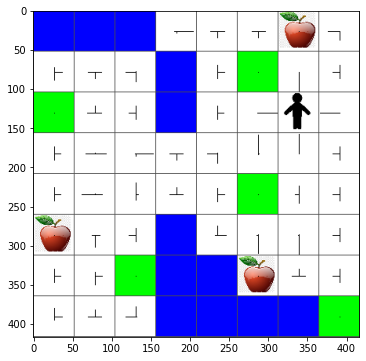

In [166]:
#m.random_start()
m.plot(Q, energy=5,fatigue=2)

## Checking the Policy

Since Q-Table lists the "attractiveness" of each action at each state, it is quite easy to use it to define the efficient navigation in our world. In the simplest case, we can just select the action corresponding to the highest Q-Table value:

In [181]:
# code block 9

def maxarg_policy(m):
    x,y = m.human
    while True:
        weights = normalize(Q[x,y,m.energy,m.fatigue])
        action = list(actions.items())[np.argmax(weights)]
        new_pos = m.move_pos(m.human, action[1])
        return action

# Make 100 walk experiments and print the average path length / number of times we encountered the wolf.
deaths = 0
runs = 0.00001
total_length = 0
for run in range(100):
    m.random_start()
    result = walk(m, maxarg_policy)
    #print(f"result: {result} energy: {m.energy}, fatigue: {m.fatigue}")
    if result < 0:
        deaths += 1
    else:
        total_length += result
        runs += 1

print(f"In 100 runs: died {deaths} times, average path length: {total_length / runs}")
        

In 100 runs: died 1 times, average path length: 9.595958626670846


If you try the code above several times, you may notice that sometimes it just "hangs", and you need to press the STOP button in the notebook to interrupt it. 

> **Task 1:** Modify the `walk` function to limit the maximum length of path by a certain number of steps (say, 100), and watch the code above return this value from time to time.

> **Task 2:** Modify the `walk` function so that it does not go back to the places where is has already been previously. This will prevent `walk` from looping, however, the agent can still end up being "trapped" in a location from which it is unable to escape.

In [13]:

# code block 10

## Investigating the Learning Process

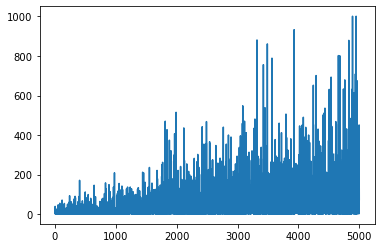

In [14]:
plt.plot(lpath)

## Exercise
## A more realistic Peter and the Wolf world


